# 1. Загрузка и подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
sns.set(style="whitegrid")
import warnings
warnings.simplefilter("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st

rnd_state = 702

Прочитаем данные геологоразведки трёх регионов и изучим их. Создадим вспомогательный словарь из данных для трех регионов для удобства обращения.

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

data_dict = {'Регион 1' : data_0, 'Регион 2' : data_1, 'Регион 3' : data_2}

for data in data_dict:
    print(data)
    display(data_dict[data].head(5))
    print()

Регион 1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Регион 2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Регион 3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Признаки `f0, f1 и f2` имеют разный масштаб в пределах каждого региона. Также можно заметить, что объем запасов двух скважин в регионе 2 совпадает с точностью до 6 знака после запятой - это странно. Изучим данные подробнее с помощью `describe()`.

In [3]:
for data in data_dict:
    print(data)
    display(data_dict[data].describe())
    print()

Регион 1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Регион 2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Регион 3


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Среднее значение целевого признакак в регионах 1 и 3 почти в полтора раза больше, чем в регионе 2, стандартное отклонение везде приблизительно одинаковое.

На основании имеющихся данных можно предположить, что разработка скважин в регионе 2 неперспективна. Позже проверим эту гипотезу. 

Посмотрим на распределение целевого признака с помощью гистограмм.

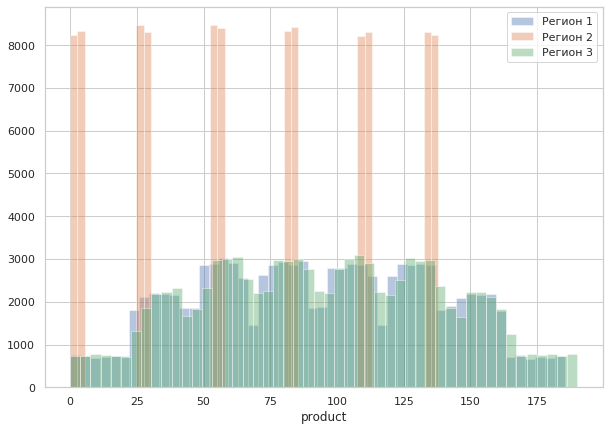

In [4]:
for data in data_dict:
    ax = sns.distplot(data_dict[data].loc[:,'product'], bins = 50, norm_hist = False, kde = False, label = data)
ax.legend()
plt.show()

Мы видим, что распределение целевого признака в регионе 1 и 3 выглядит адекватно, тогда как в регионе 2 есть только 12 уникальных значений объема сырья в скважине, что очень подозрительно. Для каждого из уникальных значений существует более 8000 скважин с таким объемом сырья. Возможно, при передаче данных геологоразведки была допущена ошибка - об этом необходимо сообщить отвественным за сбор и передачу данных специалистам.

# 2. Обучение и проверка модели

Создадим функцию, которая будет обучать модель для каждого региона. На вход функция будет получать датафрейм, а возвращать будет среднее значение предсказаний, RMSE, значения целевого признака и предсказания целевого признака.

In [5]:
def lr_train(data):

    features = data.drop(['id','product'], axis = 1)
    target = data['product']

    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                              test_size=0.25, random_state=rnd_state)
    cols = ['f0', 'f1', 'f2']
    
    model = LinearRegression()
    model.fit(features_train, target_train)

    y_true = target_valid
    y_pred = model.predict(features_valid)
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    pred_mean = y_pred.mean()
    y_pred = pd.Series(y_pred)
    y_true = y_true.reset_index(drop = True)
    return pred_mean, rmse, y_true, y_pred

Найдем для каждого региона средний запас предсказанного сырья и RMSE модели. Также создадим два списка, в которых будут находиться предсказания целевого признака и сам целевой признак для всех регионов.

In [6]:
predicts = []
targets = []
for data in data_dict:
    dataframe = data_dict[data]
    pred_mean, rmse, y_true, y_pred = lr_train(dataframe)
    targets.append(y_true)
    predicts.append(y_pred)
    print(data)
    print('Срений запас предсказанного сырья: \033[1m{:.2f}\033[0m тыс. баррелей'.format(pred_mean))
    print('RMSE модели: \033[1m{:.2f}\033[0m тыс. баррелей'.format(rmse))
    print()

Регион 1
Срений запас предсказанного сырья: 92.52 тыс. баррелей
RMSE модели: 37.56 тыс. баррелей

Регион 2
Срений запас предсказанного сырья: 68.71 тыс. баррелей
RMSE модели: 0.89 тыс. баррелей

Регион 3
Срений запас предсказанного сырья: 94.94 тыс. баррелей
RMSE модели: 40.41 тыс. баррелей



Как мы видим, средний запас предсказанного сырья для региона 1 и 3 также почти в полтора больше, чем во втором регионе, но при этом и среднеквадратическая ошибка модели для них значительно больше. Ошибка для региона 2 составляет всего 0.89 тыс. баррелей - модель очень хорошо справилась с предсказаниями.

# 3. Подготовка к расчёту прибыли

Ключевые значения для расчетов сохраним в отдельных переменных. С помощью этих переменных найдем минимальный объем сырья для безубыточной разработки новой скважины.

In [7]:
budget = 10 ** 10 # бюджет на разработку скважин в регионе
ppb = 450_000 # доход с 1 тыс. баррелей
count = 200 # количество скважин в регионе

min_volume = budget / ppb / count

print('Минимальный объем сырья для безубыточной разработки новой скважины: {:.2f} тыс. баррелей'.format(min_volume))

Минимальный объем сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей


Сравним средний запас сырья в скважине с минимальным объемом сырья для безубыточной разработки.

In [8]:
for data in data_dict:
    dataframe = data_dict[data]
    mean = dataframe['product'].mean()
    print('{}. Срений запас сырья в скважине: \033[1m{:.2f}\033[0m тыс. баррелей.'.format(data, mean))
    print('Минимальный объем сырья для безубыточной разработки: \033[1m{:.2f}\033[0m тыс. баррелей.'.format(min_volume))
    if mean >= min_volume:
        print('Средний запас сырья превосходит минимальный объем для безубыточной разработки.')
    else: print('Средний запас сырья меньше минимального объема для безубыточной разработки.')
    print()

Регион 1. Срений запас сырья в скважине: 92.50 тыс. баррелей.
Минимальный объем сырья для безубыточной разработки: 111.11 тыс. баррелей.
Средний запас сырья меньше минимального объема для безубыточной разработки.

Регион 2. Срений запас сырья в скважине: 68.83 тыс. баррелей.
Минимальный объем сырья для безубыточной разработки: 111.11 тыс. баррелей.
Средний запас сырья меньше минимального объема для безубыточной разработки.

Регион 3. Срений запас сырья в скважине: 95.00 тыс. баррелей.
Минимальный объем сырья для безубыточной разработки: 111.11 тыс. баррелей.
Средний запас сырья меньше минимального объема для безубыточной разработки.



Во всех регионах среднего запаса сырья в скважине не хватает для безубыточной разработки. Таким образом, необходимо предсказать 
самые прибыльные скважины (скважины с наибольшим предсказанным объемом сырья) и проверить, будет ли в этом случае разработка безубыточной.

# 4. Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели. Функция получает на вход значения целевого признака (объем в скважине), предсказания объемов и количество скважин. Из значений целевого признакак функция отбирает те значения, которые соответствуют наибольшему количеству сырья, предсказанному моделью. Далее считается прибыль - суммируем количество сырья в выбранных скважинах, умножаем на стоимость сырья и вычитаем расходы на разработку скважин. Прибыль вычисляется в млн. руб.

In [9]:
# target - целевой признак
# predict - предсказания целевого признака
# count - количество отбираемых значений

def revenue(target, predict, count):
    predict_sorted = predict.sort_values(ascending=False)
    selected = target[predict_sorted.index][:count]
    total_product = selected.sum()
    revenue = (total_product * ppb - budget) / 10**6
    return revenue

# 5. Расчёт рисков и прибыли для каждого региона

Создадим функцию для расчета 95%-ого доверительного интервала для значений выборки. Для этого найдем выборочное стандартное отклонение `σ`, тогда доверительный интервал будет равен `x̅ ± 1.96⋅σ`.

In [10]:
def interval(values):
    mean = values.mean()
    sqr_list = []
    for i in values:
        sqr = (i - mean) ** 2
        sqr_list.append(sqr)
    sigma = (sum(sqr_list) / (len(values) - 1)) ** 0.5
    lower, upper = (mean - 1.96 * sigma), (mean + 1.96 * sigma)
    
    print('95%-ый доверительный интервал для значений выборки: от {:.2f} до {:.2f} млн. руб.'
          .format(lower, upper))

Для расчета рисков и прибыли воспользуемся техникой `Bootstrap`. Создадим функцию, которая создает 1000 подвыборок из целевого признака и предсказаний признака (размер каждой выборки равен 500 - количество точек при исследовании региона), а для каждой выборки найдем прибыль с помощью функции `revenue`, которая описана выше.

Функция `Bootstrap` выведет на экран среднюю прибыль, 95%-ый доверительный интервал для прибыли, риск убытков и гистограмму прибыли.

In [11]:
state = np.random.RandomState(rnd_state)

def bootstrap(target, predict):
    values = []
    for i in range(1000):
        target_subsample = target.sample(500, replace=True, random_state = state)
        predict_subsample = predict[target_subsample.index]
    
        values.append(revenue(target_subsample, predict_subsample, count))

    values = pd.Series(values)
    mean = values.mean()
    
    negatives = [x for x in values if x < 0] # создадим список из отрицательных значений прибыли
    risk = len(negatives) / len(values) # риск убытков - отношение количества отрицательных значений прибыли к общему
    
    print("Средняя прибыль: {:.2f} млн. руб.".format(mean))
    
    interval(values)
    
    print("95%-ый доверительный интервал для прибыли по квантилям: от {:.2f} до {:.2f} млн. руб."
          .format(values.quantile(0.025), values.quantile(0.975)))
    print("Риск убытков: {:.2%}".format(risk))
    sns.distplot(values, bins = 50, kde = True)
    plt.title('Гистограмма прибыли', fontsize=20)
    plt.show()

Для каждого из регионов вызовем функцию `Bootstrap` с выводом требуемой информации.

Регион 1
Средняя прибыль: 427.14 млн. руб.
95%-ый доверительный интервал для значений выборки: от -110.32 до 964.59 млн. руб.
95%-ый доверительный интервал для прибыли по квантилям: от -81.04 до 988.11 млн. руб.
Риск убытков: 6.10%


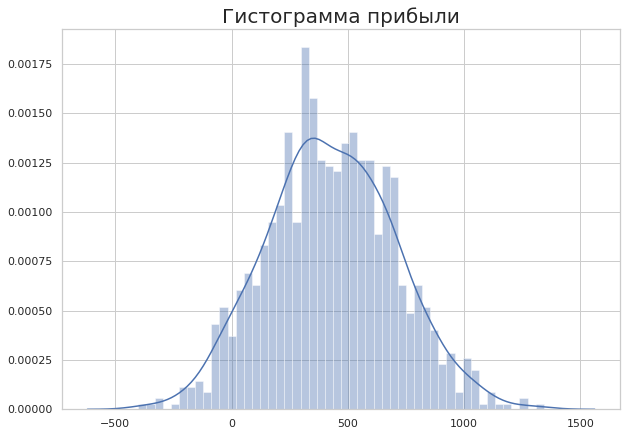



Регион 2
Средняя прибыль: 499.77 млн. руб.
95%-ый доверительный интервал для значений выборки: от 72.45 до 927.09 млн. руб.
95%-ый доверительный интервал для прибыли по квантилям: от 67.40 до 938.65 млн. руб.
Риск убытков: 1.00%


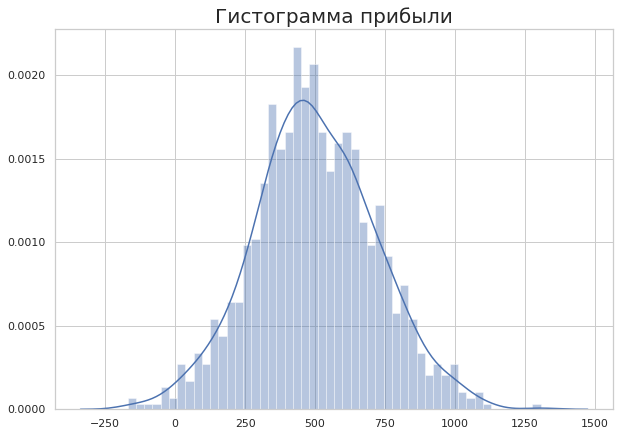



Регион 3
Средняя прибыль: 368.58 млн. руб.
95%-ый доверительный интервал для значений выборки: от -191.05 до 928.21 млн. руб.
95%-ый доверительный интервал для прибыли по квантилям: от -181.99 до 946.01 млн. руб.
Риск убытков: 8.90%


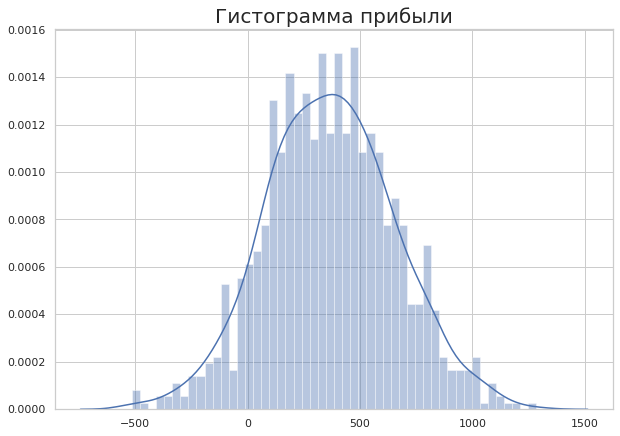

In [12]:
for i in range(3):
    print('Регион', i+1)
    bootstrap(targets[i], predicts[i])
    print()
    print()

## Выводы.

Среди трех регионов только во втором регионе риск убытков менее 2.5% - он составляет **1.00%**. При этом во втором регионе также самая высокая средняя прибыль - она составляет **499.77 млн. руб**. при 95%-ом доверительном интервале **от 72.45 до 927.09 млн. руб** - логично, что в этом интервале нет убытков, ведь риск убытков составил менее 2.5%. Также очевидно, что на основании предсказанных моделью данных для разработки скважин лучше выбрать именно второй регион.

Наша изначальная гипотеза о том, что самыми перспективными для разработки являются регионы 1 и 3, не подтвердилась. У второго региона получилась самая высокая средняя прибыль и самые низкие риски - все потому, что модель именно второго региона допускает меньше всего ошибок при прогнозировании целевого признака.

Но стоит не забывать, что распределение целевого признака во втором регионе очень странное. Рекомендуем перепроверить данные геологоразведки для второго региона на ошибки и провести анализ заново при их обнаружении.